<u><center><h1>Udacity MLND Capstone Project</h1>
<h2>Plant Seedling Classfication</h2></center></u> 
<p> This project is taken from the <a href='https://www.kaggle.com/c/plant-seedlings-classification'>kaggle competition</a>. It aims at detecting plant as a part of one of the 12 categories and will help in effective weed management.</p>
<p> The code below is broken down in the following sections:
    <ul>
        <li> Data Exploration</li>
        <li> Pre-processing of data </li>
        <li> Creating CNN Model </li>
        <li> Comparing Results </li>

## 1. DATA EXPLORATION

### Loading the data set

In [9]:
# perform necessary imports
from sklearn.datasets import load_files       
from glob import glob
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split                  
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.applications.xception import Xception
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.core import Activation
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

In [2]:
''' 
Here we are going to load our training and test dataset 
and see the count of files in both of them as well as the defined categories of lant ssedling data set.
'''
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    plant_files = np.array(data['filenames'])
    plant_targets = np_utils.to_categorical(np.array(data['target']), 12)
    return plant_files, plant_targets

# load train and testdatasets
train_files, train_targets = load_dataset('seedlingdata/train')

# load list of plant seedling categories
categories = [item[19:-1] for item in sorted(glob("seedlingdata/train/*/"))]

# find count of files under test data
test_path, test_dirs, test_files = next(os.walk("seedlingdata/test"))
test_file_count = len(test_files)

# print statistics about the dataset
print('---------------')
print('TRAINING DATA')
print('---------------')
print('There are %d training plant seedling images.' % len(train_files))
print('There are %d total plant seedling categories' % len(categories))
print('List of categories:',categories)

print('---------------')
print('TEST DATA')
print('---------------')
print('There are %d test plant seedling images.' % test_file_count)

---------------
TRAINING DATA
---------------
There are 4750 training plant seedling images.
There are 12 total plant seedling categories
List of categories: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
---------------
TEST DATA
---------------
There are 794 test plant seedling images.


### Data Distribution

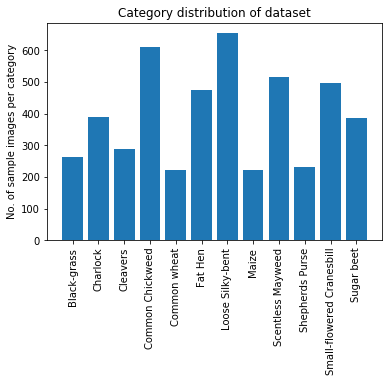

-----------------
DATA DISTRIBUTION
-----------------
1. Black-grass has 263 records
2. Charlock has 390 records
3. Cleavers has 287 records
4. Common Chickweed has 611 records
5. Common wheat has 221 records
6. Fat Hen has 475 records
7. Loose Silky-bent has 654 records
8. Maize has 221 records
9. Scentless Mayweed has 516 records
10. Shepherds Purse has 231 records
11. Small-flowered Cranesbill has 496 records
12. Sugar beet has 385 records


In [3]:
category_count = np.sum(train_targets, axis=0)
'''
Function for displaying categorical data distribution to check if dataset is balanced
TODO: data augmentation if dataset is unbalanced
'''
def categorical_dist_graph(categories, count):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(categories)), count)
    ax.set_ylabel('No. of sample images per category')
    ax.set_xticks(np.arange(len(categories)))
    ax.set_xticklabels(categories, rotation = 'vertical')
    ax.set_title('Category distribution of dataset')
    plt.show()

categorical_dist_graph(categories, category_count)

print("-----------------")
print("DATA DISTRIBUTION")
print("-----------------")
for i in range(0,12):
    print('%d. %s has %d records' % (i+1, categories[i], category_count[i]))

### Show Sample Images from each category

In [4]:


# Create a dictionary to store images with categories as key
# Using a default dictionary to avoid checking if key is set or not

def get_images_per_category():
    images_per_category = defaultdict(list)
    for category in categories:
        for i in range(len(train_files)):
            if category in train_files[i]: # check if category name exists in the file path
                images_per_category[category].append(train_files[i]) # add the file name to the category 
    return images_per_category            

Black-grass


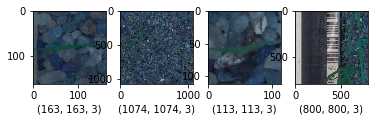

Charlock


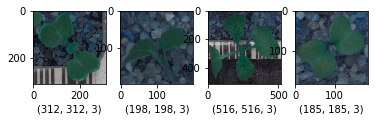

Cleavers


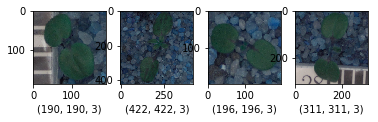

Common Chickweed


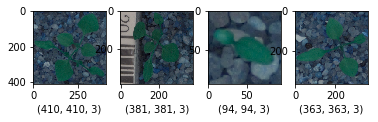

Common wheat


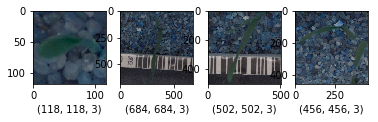

Fat Hen


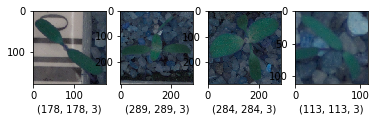

Loose Silky-bent


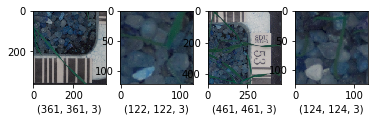

Maize


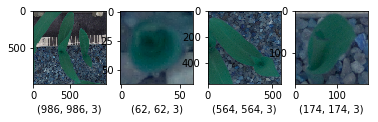

Scentless Mayweed


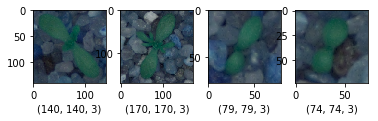

Shepherds Purse


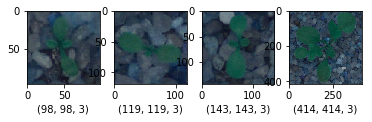

Small-flowered Cranesbill


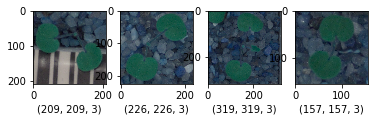

Sugar beet


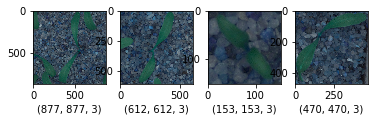

In [5]:
def display_sample(count):
    # iterate over the dictionary and print images as per the count
    images_per_category = get_images_per_category()
    for category in images_per_category:
        print(category)
        fig = plt.figure()
        i = 0
        while(i < count):
            img = cv2.imread(images_per_category[category][i]) # read file
            fig.add_subplot(1,count,i+1)
            plt.xlabel(img.shape)
            plt.imshow(img)    
            i += 1
        plt.show()

display_sample(4)

## 2. Data Pre-Processing

In this section we will process our data before passing it to the model. For the pre-processing step I plan on doing image augmentation. This will be onlineimage augmentation so that the size of the physical size of the data set does not increase, instead augmentation will be preformed on the fly. This will have some effect on the total time of the alogirthm execution.

### Split Data into Training, Validation and Test set

In [8]:
# We will split our training data set into Train, Validation and Test set

#1. Split training -> Train_Validation and Test set
# Split is done in to keep Training data as 90% and Test data as 10%
feature_train_valid, feature_test, label_train_valid, label_test = train_test_split(
    train_files, train_targets, test_size=0.10, random_state=32, shuffle=True)


#2. Split the remaining Train set into -> Train and Validation set
# Split is done to keep Training data as 80% and Validation data as 20%
feature_train, feature_valid, label_train, label_valid = train_test_split(
    feature_train_valid, label_train_valid, test_size=0.20, random_state=32, shuffle=True)

# Print details of data splits

print("Size of complete data set:",len(train_files))
print("-------------")
print("SPLITTING DATA INTO TRAINING, VALIDATION and TEST")
print("-------------")


#print("Size of training & validation data set:",len(feature_train_valid))
print("Size of Training dataset:",len(feature_train))
print("Size of Validation data set:",len(feature_valid))
print("Size of Test data set:",len(feature_test))

Size of complete data set: 4750
-------------
SPLITTING DATA INTO TRAINING, VALIDATION and TEST
-------------
Size of Training dataset: 3420
Size of Validation data set: 855
Size of Test data set: 475


In [10]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, dataset_name):
    description = 'Loading {} dataset'.format(dataset_name)
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths, desc=description)]
    return np.vstack(list_of_tensors)

# pre-process the data for Keras
train_tensors = paths_to_tensor(feature_train, 'training').astype('float32')/255
valid_tensors = paths_to_tensor(feature_valid, 'validation').astype('float32')/255
test_tensors = paths_to_tensor(feature_test, 'test').astype('float32')/255

### Image Augementation

In [15]:
# create the data augmenter
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode="nearest")

https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

In [16]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1score(y_true, y_pred, beta =1):
    '''Calculates the f-measure (f1 score), the harmonic mean of precision and recall.
        This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    f1score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return f1score

## 3. Creating a CNN model

In this section we will first create a benchmark model and get the f1 score of the benchmark model. Once we are done with that, we will create a 2 models using transfer learning. Once using Inception model and the other using the Xception model.

### Benchmark Model

In [17]:
small_conv_nn = Sequential()

input_shape = (224,224,3)

small_conv_nn.add(Conv2D(10, (5, 5), padding="same", input_shape=input_shape))
small_conv_nn.add(Activation("relu"))
small_conv_nn.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
small_conv_nn.add(Conv2D(20, (5, 5), padding="same", input_shape=input_shape))
small_conv_nn.add(Activation("relu"))
small_conv_nn.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
small_conv_nn.add(Conv2D(30, (5, 5), padding="same", input_shape=input_shape))
small_conv_nn.add(Activation("relu"))
small_conv_nn.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
small_conv_nn.add(Flatten())

small_conv_nn.add(Dense(2048))
small_conv_nn.add(Activation("relu"))
small_conv_nn.add(Dense(12))
small_conv_nn.add(Activation("softmax"))
small_conv_nn.summary()

NameError: name 'Sequential' is not defined

In [37]:
batch_size =16
epochs = 10

# compile the model
small_conv_nn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[f1score])

# create checkpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch2.hdf5', 
                               verbose=1, save_best_only=False)

# fit the model
small_conv_nn.fit_generator(generator= aug.flow(train_tensors, label_train, batch_size=batch_size), 
                    validation_data=(valid_tensors, label_valid),
                    steps_per_epoch=(len(train_tensors)/batch_size),
                   epochs=epochs, verbose=1, callbacks=[checkpointer])

Epoch 1/20
214/213 [==============================] - 29s - loss: 2.0529 - f1score: 0.0800 - val_loss: 1.6663 - val_f1score: 0.2787
Epoch 2/20
214/213 [==============================] - 27s - loss: 1.6209 - f1score: 0.2495 - val_loss: 1.2406 - val_f1score: 0.4317
Epoch 3/20
214/213 [==============================] - 27s - loss: 1.3499 - f1score: 0.4302 - val_loss: 1.0173 - val_f1score: 0.5515
Epoch 4/20
214/213 [==============================] - 27s - loss: 1.1524 - f1score: 0.5409 - val_loss: 0.8851 - val_f1score: 0.6468
Epoch 5/20
214/213 [==============================] - 27s - loss: 0.9754 - f1score: 0.6385 - val_loss: 0.7287 - val_f1score: 0.7328
Epoch 6/20
214/213 [==============================] - 27s - loss: 0.8327 - f1score: 0.6924 - val_loss: 0.9267 - val_f1score: 0.6364
Epoch 7/20
214/213 [==============================] - 27s - loss: 0.7493 - f1score: 0.7339 - val_loss: 0.5708 - val_f1score: 0.7977
Epoch 8/20
214/213 [==============================] - 28s - loss: 0.6637 - f

In [37]:
'''
    Function to evaluate the performance of the model and confusion matrix
    returns Performance Metric - f1 score
    And confusion matrix
'''
def evaluate_model(model, weights_path, x_tensors, y_tensors):
    model.load_weights(weights_path)
    y_pred = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in x_tensors]
    y_true = np.argmax(y_tensors, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    performance = f1_score(y_true, y_pred, average ='micro')
    return performance, cm

benchmark_performance = evaluate_model(small_conv_nn, 'saved_models/weights.best.from_scratch2.hdf5', test_tensors, label_test)
print('Performance evaluated by f1 score for the benchmark model is: ', benchmark_performance)

**The f1 score of the Benchmark model is 0.842**

### Model created via Transfer Learning
Transfer Learning is the process of taking a pre-trained network and adapting the neural network to new, differen data set.
There our 4 cases of transfer learning (which can be found in the proposal document<>), out of which ours is the second case, where the new dataset is small and different from the previous dataset. Following steps need to be taken with the pre-trained network to fit it with the palnt-seedling dataset:
* Slice off most of the pre-trained layers near the beginning of the network
* Add to the remaining pre-trained layers a new fully connected layer that matches the number of classes in the new data set
* Randomize the weights of the new fully connected layer; freeze all the weights from the pre-trained network
* Train the network to update the weights of the new fully connected layer

We are going to take the result using the Inception V3 model and then the Xception model

### A) Inception V3

In [30]:
#https://keras.io/applications/

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [31]:
def get_trainable_layers(model):
    sum = 0
    for layer in base_model.layers:
        if(layer.trainable):
            sum += 1 
    return sum

print("Total trainable layers in Inception V3 model", get_trainable_layers(base_model))

# We will freeze the first 150 layers by making them non-trainable
for layer in base_model.layers[:150]:
    layer.trainable = False

print ("Total trainable layers after freezing top 150 layers:", get_trainable_layers(base_model))

Total trainable layers in Inception V3 model 310
Total trainable layers after freezing top 150 layers: 161


In [33]:
inception_transfer_model = base_model.output
inception_transfer_model = GlobalAveragePooling2D()(inception_transfer_model)
inception_transfer_model = Dense(12, activation='softmax')(inception_transfer_model) 

inception_v3 = Model(input = base_model.input, output = inception_transfer_model)
inception_v3.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_377 (Conv2D)              (None, 111, 111, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_377 (BatchNo (None, 111, 111, 32)  96                                           
____________________________________________________________________________________________________
activation_377 (Activation)      (None, 111, 111, 32)  0                                            
___________________________________________________________________________________________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


In [36]:
batch_size =16
epochs = 10

# compile the model
inception_v3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[f1score])

# create the data augmenter
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode="nearest")

# create checkpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inception_v3.hdf5', 
                               verbose=1, save_best_only=False)

# fit the model
inception_v3.fit_generator(generator= aug.flow(train_tensors, label_train, batch_size=batch_size), 
                    validation_data=(valid_tensors, label_valid),
                    steps_per_epoch=(len(train_tensors)/batch_size),
                   epochs=epochs, verbose=1, callbacks=[checkpointer])

Epoch 1/10
214/213 [==============================] - 115s - loss: 1.0896 - f1score: 0.6055 - val_loss: 3.9148 - val_f1score: 0.4659
Epoch 2/10
214/213 [==============================] - 71s - loss: 0.5047 - f1score: 0.8283 - val_loss: 6.3628 - val_f1score: 0.4711
Epoch 3/10
214/213 [==============================] - 71s - loss: 0.4025 - f1score: 0.8662 - val_loss: 0.7774 - val_f1score: 0.8477
Epoch 4/10
214/213 [==============================] - 71s - loss: 0.3384 - f1score: 0.8866 - val_loss: 1.4182 - val_f1score: 0.7610
Epoch 5/10
214/213 [==============================] - 71s - loss: 0.3352 - f1score: 0.8831 - val_loss: 0.3086 - val_f1score: 0.9129
Epoch 6/10
214/213 [==============================] - 71s - loss: 0.2727 - f1score: 0.9078 - val_loss: 0.4374 - val_f1score: 0.9020
Epoch 7/10
214/213 [==============================] - 71s - loss: 0.2563 - f1score: 0.9120 - val_loss: 0.3138 - val_f1score: 0.9263
Epoch 8/10
214/213 [==============================] - 71s - loss: 0.2243 - 

In [40]:
inception_v3_performance = evaluate_model(inception_v3, 'saved_models/weights.best.inception_v3.hdf5',
                                          test_tensors, label_test)
print('Performance evaluated by f1 score for the Inception V3 model is: ', inception_v3_performance)

Performance evaluated by f1 score for the Inception V3 model is:  (0.88421052631578945, array([[22,  0,  0,  0,  0,  0,  4,  0,  1,  0,  0,  0],
       [ 1, 34,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0, 22,  1,  0,  0,  0,  0,  3,  0,  3,  2],
       [ 0,  0,  0, 61,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  0,  0,  0, 21,  1,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0, 45,  0,  1,  0,  0,  0,  1],
       [20,  0,  0,  0,  0,  2, 38,  0,  2,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0, 21,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0, 56,  0,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  2, 20,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 45,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0, 35]]))


### B) Xception

In [53]:
base_model_xception = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
count =0
for layer in base_model_xception.layers[:75]:
    layer.trainable = False
y = base_model_xception.output
predictions = Dense(12, activation = 'softmax')(y)
model_xception = Model(input=base_model_xception.input, output=predictions)
model_xception.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 111, 111, 32)  864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 111, 111, 32)  128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 111, 111, 32)  0                                            
___________________________________________________________________________________________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


In [54]:
batch_size =16
epochs = 10

# compile the model
model_xception.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[f1score])

# create the data augmenter
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode="nearest")

# create checkpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception.hdf5', 
                               verbose=1, save_best_only=False)

# fit the model
model_xception.fit_generator(generator= aug.flow(train_tensors, label_train, batch_size=batch_size), 
                    validation_data=(valid_tensors, label_valid),
                    steps_per_epoch=(len(train_tensors)/batch_size),
                   epochs=epochs, verbose=1, callbacks=[checkpointer])

ValueError: Error when checking model target: expected dense_8 to have 4 dimensions, but got array with shape (855, 12)

In [52]:
xception_performance = evaluate_model(model_xception, 'saved_models/weights.best.xception.hdf5',
                                          test_tensors, label_test)
print('Performance evaluated by f1 score for the Xception model is: ', xception_performance)

Performance evaluated by f1 score for the Inception V3 model is:  (0.88421052631578945, array([[ 9,  0,  0,  0,  1,  0, 17,  0,  0,  0,  0,  0],
       [ 0, 28,  6,  0,  0,  1,  0,  0,  0,  2,  0,  0],
       [ 0,  0, 29,  1,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 59,  0,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 24,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 47,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 63,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 21,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  2,  0, 55,  1,  0,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  2, 17,  0,  0],
       [ 0,  0,  1,  4,  0,  0,  0,  0,  0,  7, 33,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0, 35]]))
